# Unsupervised Learning Awareness - Time Series use case

This notebook is following the progression of the Unsupervised Learning Awareness for AI Decision-makers. It provides practical illustrations in Python to understand the notions we have seen in this course.

<div class="alert alert-warning">
Author: Fabrice JIMENEZ
    
Link to course materials: https://github.com/jfabrice/ml-awareness-unsupervised-learning
</div>

## Preliminary loading with Google Colab

If you are using this notebook with Google Colab, please execute first the following cells, to retrieve the GitHub repository content and set the working directory. Otherwise, ignore these 2 cells and move to the next section.

In [ ]:
!git clone https://github.com/jfabrice/ml-awareness-unsupervised-learning.git

In [ ]:
import os
os.chdir('ml-awareness-unsupervised-learning')

## Imports and dataset presentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
df = pd.read_csv('data/dataset.csv')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
print("Shape of our dataset: "+str(df.shape))

Shape of our dataset: (138289, 5)


In [3]:
df.head()

,cycle,p1,p2,p3,p4
time,,,,,
2001-01-01 00:00:00,1,-0.805191,-1.141993,-1.328327,-1.516693
2001-01-01 00:00:01,1,-0.805191,-1.134902,-1.320393,-1.505848
2001-01-01 00:00:02,1,-0.805191,-1.117304,-1.307167,-1.505848
2001-01-01 00:00:04,1,-0.848104,-1.112276,-1.285393,-1.429076
2001-01-01 00:00:05,1,-0.906958,-1.126579,-1.302869,-1.419230


## Preprocessing, data quality control

### High level exploration

How many cycles do we have? How many points per cycle?

In [4]:
df.groupby('cycle').count()

,p1,p2,p3,p4
cycle,,,,
1,5758,5758,5758,5758
2,15302,15302,15302,15302
3,470,470,470,470
4,1402,1402,1402,1402
5,7919,7919,7919,7919
6,15301,15301,15301,15301
7,6427,6427,6427,6427
8,12267,12267,12267,12267
9,15302,15302,15302,15302


There are 15 cycles, with very different number of points per cycle.
Let's see what our parameter looks like within a cycle.

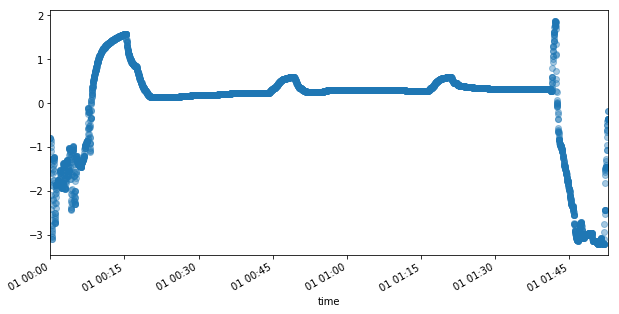

In [5]:
df[df['cycle']==1]['p1'].plot(style='o', alpha=0.4)

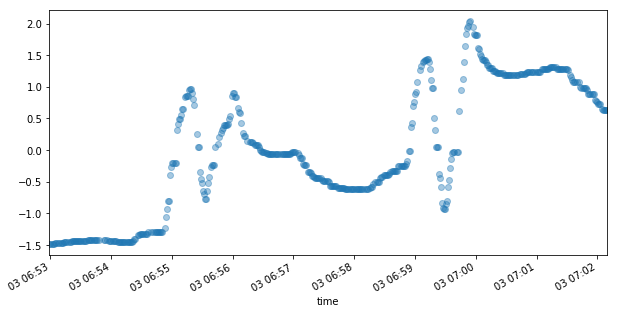

In [6]:
df[df['cycle']==3]['p1'].plot(style='o', alpha=0.4)

The values seem to be continuous (close in time = close in value) which is logical if they are physical parameters.

The parameter seems to behave quite differently in different cycles.

### Missing values or uneven time steps

<div class="alert alert-warning">
Are there missing values?
</div>

In [7]:
df.isnull().sum()

cycle    0
p1       0
p2       0
p3       0
p4       0
dtype: int64

<div class="alert alert-warning">
Are the time steps all equal?
</div>

In [8]:
timescale = pd.Series(df.index)
timescale.diff().value_counts()

0 days 00:00:01    117466
0 days 00:00:02     17708
0 days 00:00:03      2677
0 days 00:00:04       359
0 days 00:00:05        50
0 days 00:00:06        13
1 days 00:00:01        11
1 days 00:00:02         3
0 days 00:00:07         1
Name: time, dtype: int64

Time steps are not always equal to 1 second...

Let's check an example of gap of 7 seconds, to see what strategy we could use.

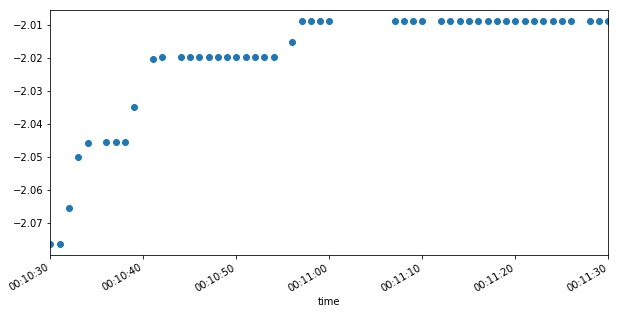

In [9]:
df['p1']['2001-01-10 00:10:30':'2001-01-10 00:11:30'].plot(style='o')

We see that values still seem to be continuous. This kind of gap can be interpolated with mean value.

<b>Conclusion</b>: We can resample data with equal steps of 1 second within each cycle, with mean interpolation (oversampling).

In [10]:
newdf = []

# For each cycle, create a small dataframe with interpolation
for c in df['cycle'].unique():
    tmp = df[df['cycle'] == c].copy()
    tmp = tmp.resample('1S').mean().interpolate(method='linear')
    
    newdf.append(tmp)
    
# Concatenate the results to have the complete dataframe
newdf = pd.concat(newdf, axis=0)
df = newdf.copy()
del newdf

Let's check we only have time steps of 1 second or 1 day (between cycles)

In [11]:
timescale = pd.Series(df.index)
timescale.diff().value_counts()

0 days 00:00:01    162684
1 days 00:00:01        11
1 days 00:00:02         3
Name: time, dtype: int64

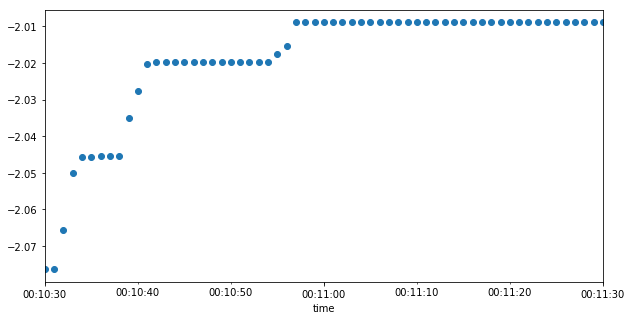

In [12]:
df['p1']['2001-01-10 00:10:30':'2001-01-10 00:11:30'].plot(style='o')

We now have clearly defined samples (windows) which contain time series regularly indexed.

### Signal regularity

When we look at the parameter values closely, we have a lot of constant steps, making the overall shape piecewise constant.

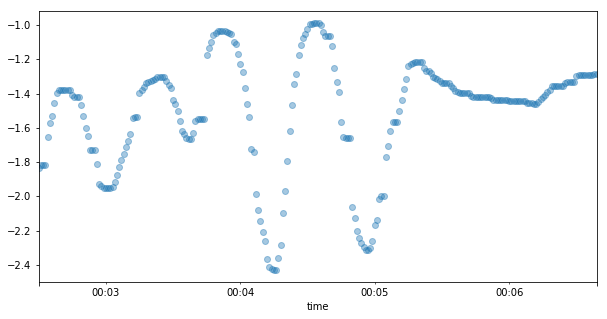

In [13]:
df[df['cycle'] == 1]['p1'][150:400].plot(style='o', alpha=0.4)

Intuitively, looking at the global shapes of signals, this kind of behavior will only add noise or pollution when we want to study the dynamics of the signal, for instance the frequencies, or the derivative. Let's filter our signals by applying a rolling mean, with a suitable window size making our signals smooth!

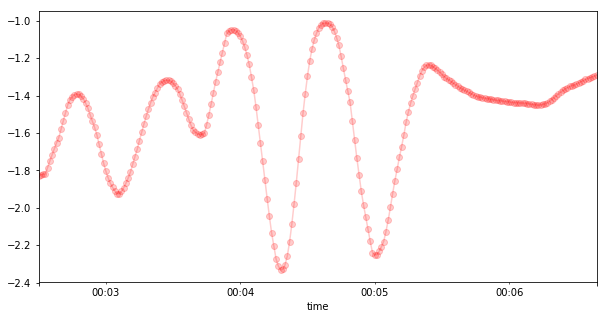

In [14]:
df[df['cycle'] == 1]['p1'][150:400].rolling('10S').mean().plot(style='r-o', alpha=0.2)

Let's apply it on all cycles and all parameters.

In [15]:
newdf = []

# For each cycle, create a small dataframe with rolling mean
for c in df['cycle'].unique():
    tmp = df[df['cycle'] == c].copy()
    tmp = tmp.rolling('10S').mean()
    
    newdf.append(tmp)
    
# Concatenate the results to have the complete dataframe
newdf = pd.concat(newdf, axis=0)
df = newdf.copy()
del newdf

df["cycle"] = df["cycle"].astype(int)

We now have smooth continuous time series for 15 flights, without missing values and with constant step size!

## Feature engineering

For the task we need to achieve, we need to detect abnormal cycles. Therefore we need to have a dataset where each cycle is described by a set of features.

<div class="alert alert-warning">
What features can now be used to summarize each cycle?
</div>

To describe a cycle we want to estimate:
   - The distribution of parameter values: info contained in summary statistics of p1, p2, p3, p4 (mean, std...)
   - The dynamics - evolution of parameter values: info contained in the derivatives of these parameters

In [16]:
# Function to be applied to the dataframe of each cycle
def computeFeatures(tab):
    res = pd.Series()
    
    # For each time series we compute the following features
    for p in [c for c in tab.columns if c != 'cycle']:
        # Mean
        res[p+'_mean'] = tab[p].mean()
        res[p+'_diff_mean'] = tab[p].diff().mean()
        # 1st decile
        res[p+'_d1'] = tab[p].quantile(0.1)
        res[p+'_diff_d1'] = tab[p].diff().quantile(0.1)
        # 9th decile
        res[p+'_d9'] = tab[p].quantile(0.9)
        res[p+'_diff_d9'] = tab[p].diff().quantile(0.9)
        # Standard deviation
        res[p+'_std'] = tab[p].std()
        res[p+'_diff_std'] = tab[p].diff().std()
    
    return res

We apply the feature computation on each cycle.

In [17]:
features = df.groupby('cycle').apply(computeFeatures)
print("Shape of the features dataset: "+str(features.shape))

Shape of the features dataset: (15, 32)


In [18]:
features.head()

,p1_mean,p1_diff_mean,p1_d1,p1_diff_d1,p1_d9,p1_diff_d9,p1_std,p1_diff_std,p2_mean,p2_diff_mean,...,p3_std,p3_diff_std,p4_mean,p4_diff_mean,p4_d1,p4_diff_d1,p4_d9,p4_diff_d9,p4_std,p4_diff_std
cycle,,,,,,,,,,,,,,,,,,,,,
1,-0.000406,0.000072,-1.583824,-0.003755,0.592651,0.002295,0.998728,0.016837,-0.000715,0.000161,...,0.999067,0.016276,-0.000831,0.000184,-2.193529,-0.002827,0.600464,0.001886,0.999735,0.013919
2,0.000617,-0.000142,-1.758348,-0.004165,0.993896,0.004141,0.999896,0.005444,0.000844,-0.000187,...,1.005792,0.012448,0.000963,-0.000207,-1.614292,-0.008061,0.879925,0.008278,1.000238,0.014094
3,-0.013855,0.003895,-1.437031,-0.027810,1.275473,0.065126,0.993802,0.048708,-0.011211,0.002793,...,0.989856,0.054349,-0.009119,0.002333,-1.282565,-0.057660,1.165968,0.086964,0.975434,0.070011
4,-0.007114,0.001573,-1.942111,0.000000,0.713135,0.007198,1.002934,0.014770,-0.007109,0.001568,...,1.002445,0.017543,-0.006415,0.001437,-1.866900,0.000000,0.670454,0.005339,1.001815,0.016125
5,0.000366,-0.000090,-1.388928,-0.002255,1.109749,0.001462,0.999911,0.005937,0.000342,-0.000076,...,0.999864,0.006879,0.000397,-0.000093,-1.380849,-0.001719,1.105927,0.001215,0.999875,0.006297


Now let's go back to class!

## Pattern visualisation

Let's compute a PCA to look at patterns & correlations between our features!

In [19]:
from pca import pca

In [20]:
model = pca(n_components=5)
resPCA = model.fit_transform((features - features.mean())/features.std(), verbose=0)['PC']

In [21]:
resPCA.head()

,PC1,PC2,PC3,PC4,PC5
1,-2.120440,3.080237,2.721819,-0.406624,-0.691843
2,-2.893167,0.446473,0.455571,-0.633759,1.035135
3,12.674397,1.562638,-2.507397,-0.027538,0.526636
4,-0.253871,6.389818,-0.195592,-0.811805,0.419292
5,-2.781764,-0.403136,-0.973709,-0.260382,-0.263413


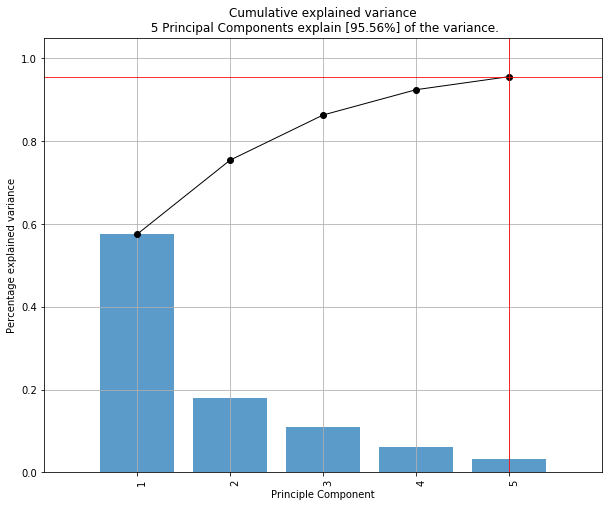

<Figure size 720x360 with 0 Axes>

In [22]:
fig,ax = model.plot()

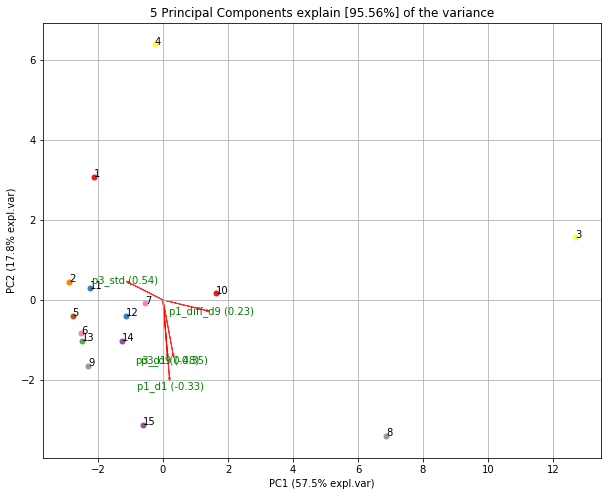

In [23]:
fig,ax = model.biplot(n_feat=5, legend=False)

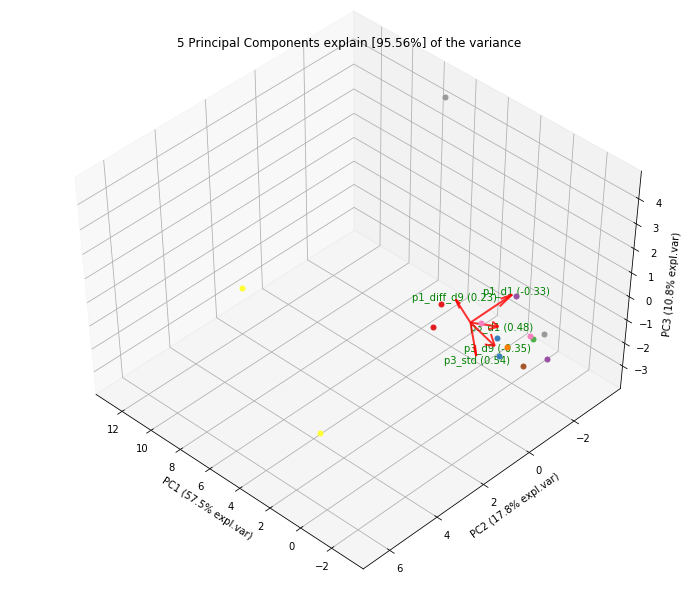

In [24]:
fig,ax = model.biplot3d(n_feat=5, legend=False)

Now let's go back to class!

## Grouping similar cycles

We can perform clustering on the 5 PCA components, let's use a hierarchical clustering to see how many groups we should have.

In [25]:
from scipy.cluster import hierarchy

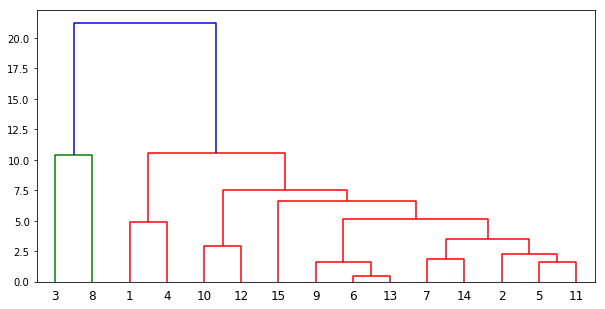

In [26]:
hac = hierarchy.linkage(resPCA, method='ward', metric='euclidean')
dendrogram = hierarchy.dendrogram(hac, labels=features.index.map(int))

A choice of 5 clusters seems reasonable! Let's cut the dendrogram at 4 groups.

In [27]:
features['cluster'] = hierarchy.cut_tree(hac,5).flatten()

Let's visualize the clusters in the PCA projection.

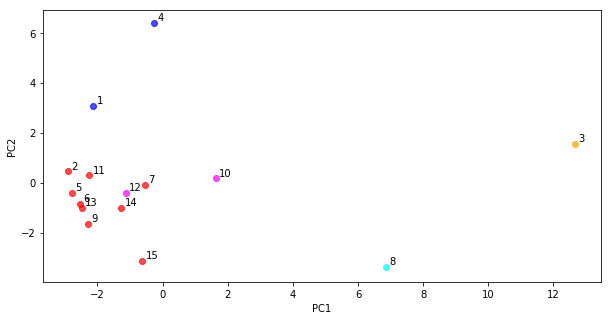

In [28]:
PCx = 'PC1'
PCy = 'PC2'

###############################
colors = ['blue','red','orange','cyan', 'magenta']
fig, ax = plt.subplots()
xl = plt.xlabel(PCx)
yl = plt.ylabel(PCy)
for i in range(len(resPCA)):
    row = resPCA.iloc[i]
    ax.scatter(row[PCx], row[PCy], c=colors[int(features['cluster'].iloc[i])], alpha=0.7)
    ax.text(x=row[PCx]+0.1, y=row[PCy]+0.1, s=str(int(features.index[i])))

We suspect cycles 3, 4 and 8 to be different from the others, let's see!

Now let's go back to class!

## Identifying abnormal cycles

Since we don't have any reference of normality, we can directly exclude the novelty detection approach. We are forced to adopt outlier detection, considering that anomalies are cycles which are different from the majority.

Let's compute an Isolation Forest anomaly score and visualize it on the PCA projection.

In [29]:
from sklearn.ensemble import IsolationForest

In [30]:
clf = IsolationForest(n_estimators=200).fit(resPCA)

In [31]:
features['score'] = clf.decision_function(resPCA)

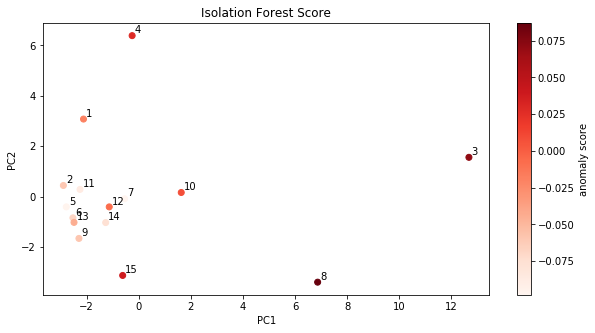

In [32]:
fig, ax = plt.subplots()
sc = ax.scatter(x=resPCA['PC1'],y=resPCA['PC2'], c=-features['score'], cmap='Reds')
fig.colorbar(sc, label='anomaly score')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Isolation Forest Score")

for i in range(len(resPCA)):
    row = resPCA.iloc[i]
    ax.text(x=row[PCx]+0.1, y=row[PCy]+0.1, s=str(int(features.index[i])))

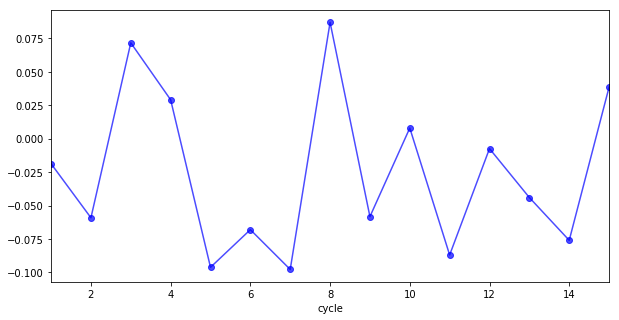

In [33]:
(-features['score']).plot(style='bo-', alpha=0.7)

We have our usual suspects: cycles 3 and 8 with good confidence, and cycles 4 and 15 with more uncertainty.

## Validation

To validate our model, we need either: 
- a validation or test set, containing the ground truth (the clusters we had to find, the real anomalies...) - <b>Strong validation strategy</b>
- a human interpretation of the results (an expert eye who is able to tell if the clusters make sense, or if the anomalies detected are real ones...) - <b>Weak validation</b>

In the frame of this use case, we don't have any validation dataset, so we would rely only on a human interpretation by an expert. We would give the expert the parameters or behaviors we suspect to be anomalies. According to their interpretation, we can go back in the different steps of this analysis to change some elements (different resampling, smoothing, choice of features, method for clustering...)

This is why it is very important not to get lost in your choices! To be able to play with these choices, to adjust according to the results validation.

Now let's go back to class to conclude!